In [1]:
import matplotlib.pyplot as plt
import numpy as np

from scipy.signal import butter, filtfilt
from pynwb import NWBHDF5IO
from nwbwidgets import nwb2widget
from nwbwidgets.utils.timeseries import align_by_time_intervals, bisect_timeseries_by_times

%matplotlib inline

In [2]:
# load the nwb files
session_id = 'S25_210913'
filename = f'Y://singer//NWBData//UpdateTask//{session_id}.nwb'

io = NWBHDF5IO(filename,'r')
nwbfile = io.read()


In [3]:
nwb2widget(nwbfile)

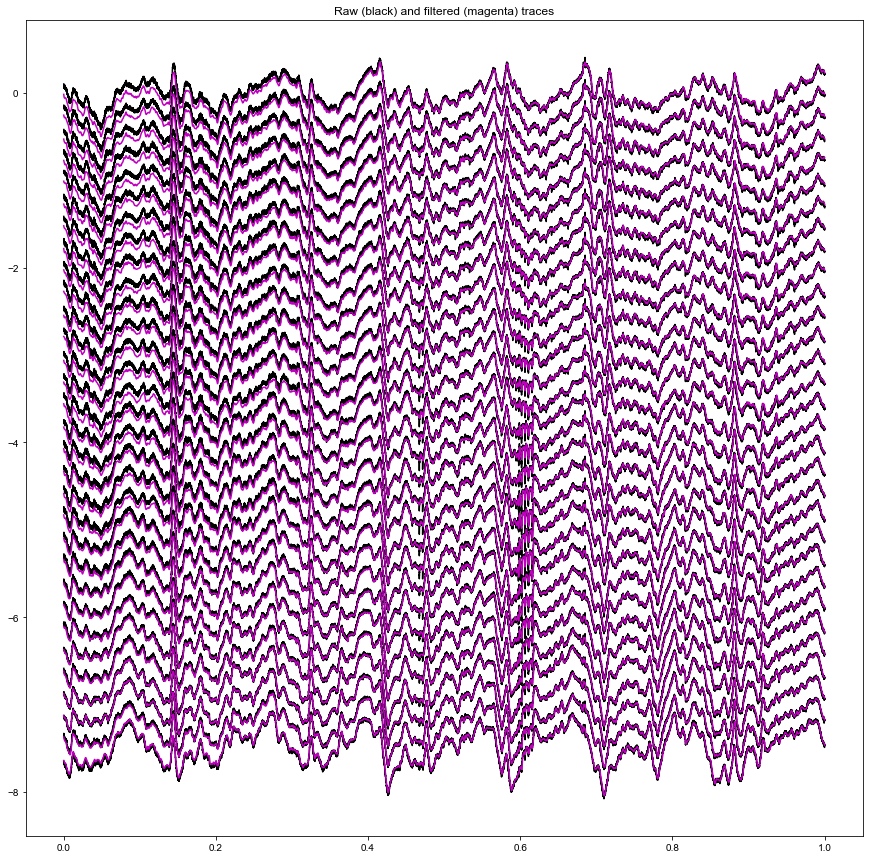

In [4]:
# plot raw and filtered timeseries data
raw_conversion_factor = nwbfile.acquisition['raw_ecephys'].conversion
raw_samp_rate = int(nwbfile.acquisition['raw_ecephys'].rate)
raw_data = nwbfile.acquisition['raw_ecephys'].data[0:raw_samp_rate,:]*raw_conversion_factor
raw_times = np.linspace(0, 1, raw_samp_rate)

lfp_conversion_factor = nwbfile.processing['ecephys']['LFP']['LFP'].conversion
lfp_samp_rate = int(nwbfile.processing['ecephys']['LFP']['LFP'].rate)
lfp_data = nwbfile.processing['ecephys']['LFP']['LFP'].data[0:lfp_samp_rate, :]*lfp_conversion_factor
lfp_times = np.linspace(0, 1, lfp_samp_rate)

fig, axes = plt.subplots(1, 1, figsize=(15,15))
for ch in range(31):
    axes.plot(raw_times, raw_data[:,ch]-0.25*ch, 'k', label='raw')
    axes.plot(lfp_times, lfp_data[:,ch]-0.25*ch, 'm', label='filtered')
    axes.set_title('Raw (black) and filtered (magenta) traces')

plt.show()

In [5]:
# plot lfp event data (ripples)
time_window = 0.25
raw_ts = nwbfile.acquisition['raw_ecephys']
ripple_time_intervals = nwbfile.processing['ecephys']['ripples']
ripple_traces = align_by_time_intervals(raw_ts, ripple_time_intervals, before=time_window, after=time_window)
durations = ripple_time_intervals['stop_time'][:] - ripple_time_intervals['start_time'][:]

electrode_df = nwbfile.electrodes.to_dataframe()
ripple_channel = electrode_df.index[electrode_df['ripple_channel'] == 1][0]

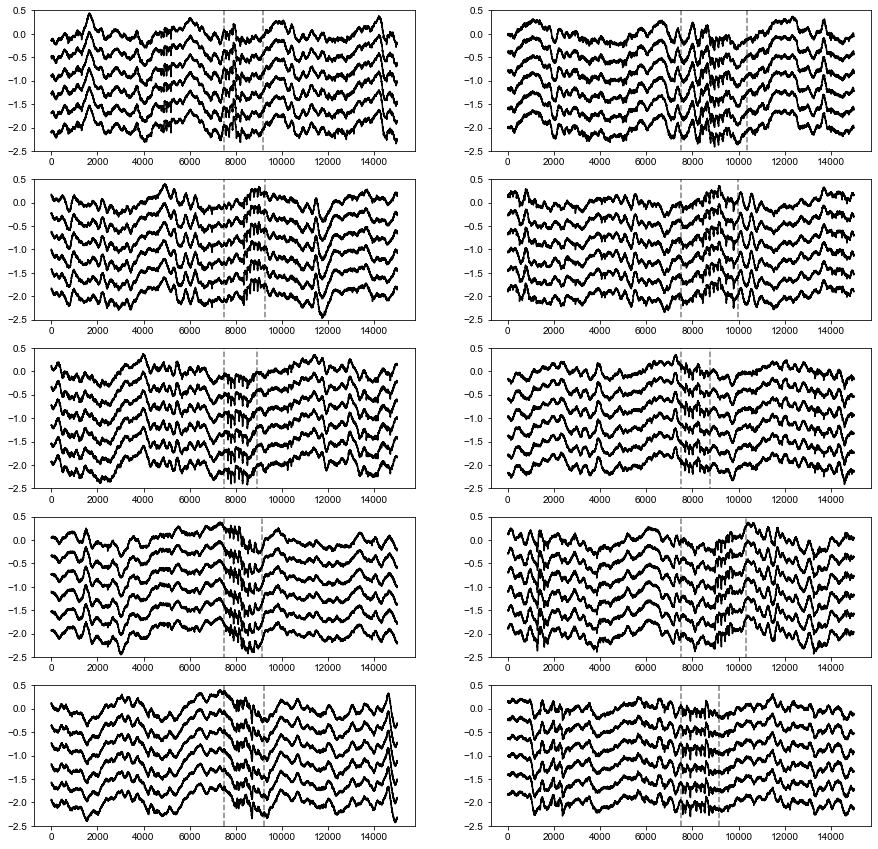

In [6]:
# plot subset of ripple events and channels around the main ripple channel
num_rows = 5
num_cols = 2
num_channels = 3
plot_num = 0
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15,15))
for ind, ripple in enumerate(ripple_traces):
    if ind < num_rows*num_cols:
        channel_range = range(ripple_channel-num_channels, ripple_channel+num_channels)
        row = int(np.floor(ind/5))
        col = int(ind-row*5)
        for ch_ind, ch in enumerate(channel_range):
            axes[col][row].plot(ripple[:,ch]*raw_conversion_factor-0.4*ch_ind, color='k')
        
        dashed_line_y = np.linspace(start=-2500, stop=500, num=100)
        dashed_line_x_start = np.zeros(100) + len(ripple[:,ch])/2
        dashed_line_x_end = dashed_line_x_start + durations[ind]*raw_ts.rate
        axes[col][row].plot(dashed_line_x_start, dashed_line_y, color='black', linestyle='dashed', alpha=0.5)
        axes[col][row].plot(dashed_line_x_end, dashed_line_y, color='black', linestyle='dashed', alpha=0.5)
        axes[col][row].set_ylim((-2.5,0.5))
plt.show()

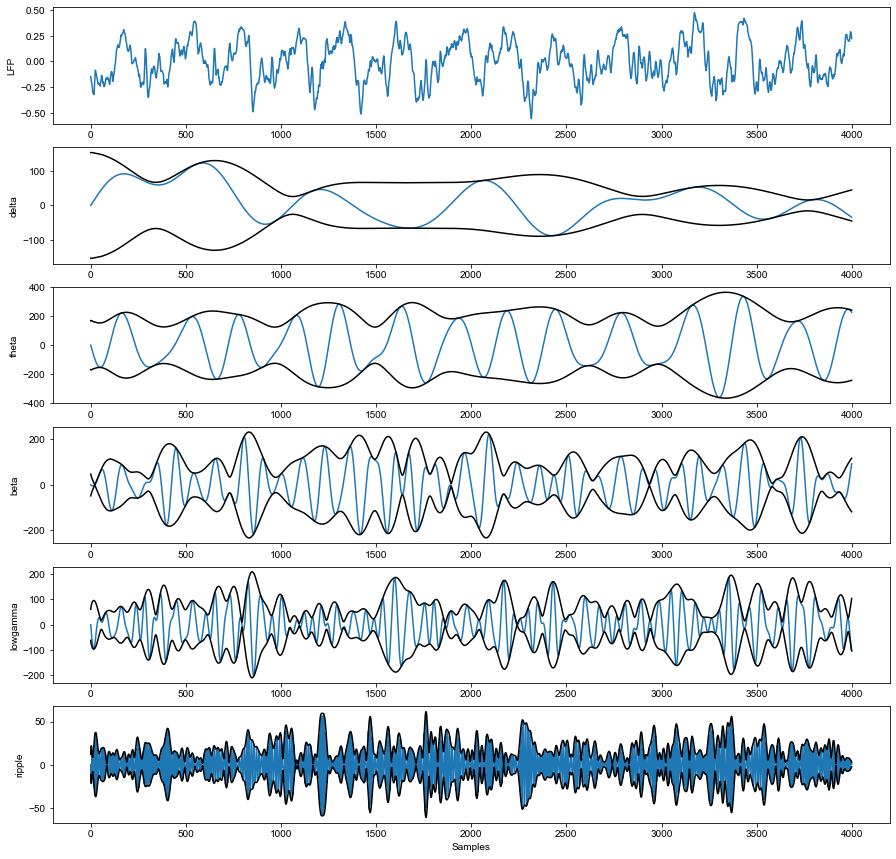

In [7]:
#plot decomposition series data
data_amp = nwbfile.processing['ecephys']['decomposition_amplitude'].data[0:lfp_samp_rate*2, 31, 0:5]
data_phase = nwbfile.processing['ecephys']['decomposition_phase'].data[0:lfp_samp_rate*2, 31, 0:5]
data_env = nwbfile.processing['ecephys']['decomposition_envelope'].data[0:lfp_samp_rate*2, 31, 0:5]
band_df = nwbfile.processing['ecephys']['decomposition_amplitude'].bands.to_dataframe()

fig, axes = plt.subplots(6, 1, figsize=(15,15))

# plot lfp
lfp_data = nwbfile.processing['ecephys']['LFP']['LFP'].data[0:lfp_samp_rate*2, :]*lfp_conversion_factor
axes[0].plot(lfp_data[:,31])
axes[0].set_ylabel('LFP')

# plot frequency bands
for band in range(5):
    axes[band+1].plot(data_amp[:,band])
    axes[band+1].plot(data_env[:,band], color='k')
    axes[band+1].plot(-1*data_env[:,band], color='k')
    axes[band+1].set_ylabel(band_df['band_name'][band])

axes[band+1].set_xlabel('Samples')

plt.show()

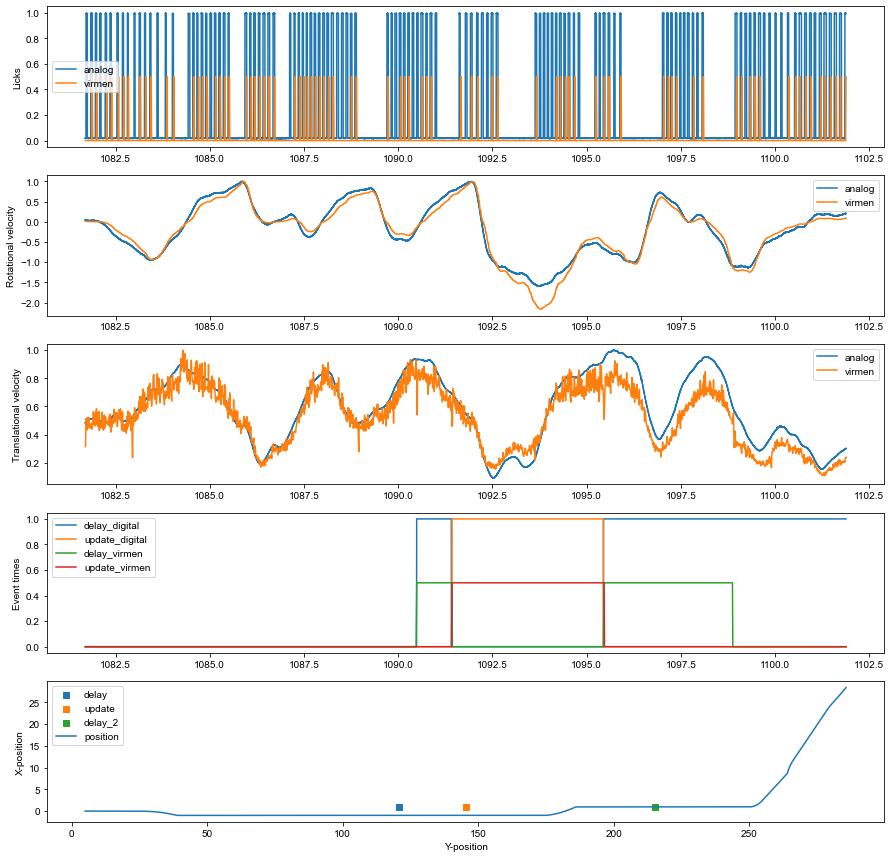

In [8]:
# plot behavior and digital events
trial_number = 40 # 40, 208 are update trials
trials_df = nwbfile.intervals['trials'].to_dataframe()
start_time = [trials_df.iloc[trial_number]['start_time']]
stop_time = [trials_df.iloc[trial_number]['stop_time']]
duration = float(stop_time[0] - start_time[0])

fig, axes = plt.subplots(5, 1, figsize=(15,15))

# get times for plotting purposes
times_ts = nwbfile.processing['behavior']['time']
times_trace = bisect_timeseries_by_times(times_ts, start_time, duration)[0]

# plot licks
licks_analog_ts = nwbfile.acquisition['licks']
licks_analog_trace = bisect_timeseries_by_times(licks_analog_ts, start_time, duration)
times_analog_trace = np.linspace(start_time[0], start_time[0]+duration, np.shape(licks_analog_trace)[1])
axes[0].plot(times_analog_trace, licks_analog_trace[0]/np.max(licks_analog_trace[0]), label='analog')

licks_ts = nwbfile.processing['behavior']['licks']['licks']
licks_trace = bisect_timeseries_by_times(licks_ts, start_time, duration)
axes[0].plot(times_trace, licks_trace[0]*0.5/np.max(licks_trace[0]), label='virmen')
axes[0].set_ylabel('Licks')
axes[0].legend()

# plot rotational velocity
rotational_velocity_analog_ts = nwbfile.acquisition['rotational_velocity']
rotational_velocity_analog_trace = bisect_timeseries_by_times(rotational_velocity_analog_ts, start_time, duration)
axes[1].plot(times_analog_trace, rotational_velocity_analog_trace[0]/np.max(rotational_velocity_analog_trace[0]), label='analog')

rotational_velocity_ts = nwbfile.processing['behavior']['rotational_velocity']
rotational_velocity_trace = bisect_timeseries_by_times(rotational_velocity_ts, start_time, duration)
axes[1].plot(times_trace, rotational_velocity_trace[0]/np.max(rotational_velocity_trace[0]), label='virmen')
axes[1].set_ylabel('Rotational velocity')
axes[1].legend()

# plot translational velocity
translational_velocity_analog_ts = nwbfile.acquisition['translational_velocity']
translational_velocity_analog_trace = bisect_timeseries_by_times(translational_velocity_analog_ts, start_time, duration)
axes[2].plot(times_analog_trace, translational_velocity_analog_trace[0]/np.max(translational_velocity_analog_trace[0]), label='analog')

translational_velocity_ts = nwbfile.processing['behavior']['translational_velocity']
translational_velocity_trace = bisect_timeseries_by_times(translational_velocity_ts, start_time, duration)
axes[2].plot(times_trace, translational_velocity_trace[0]/np.max(translational_velocity_trace[0]), label='virmen')
axes[2].set_ylabel('Translational velocity')
axes[2].legend()

# plot intervals (trial start/end, delay start/end, update start/end)
delay_df = nwbfile.intervals['delay'].to_dataframe()
update_df = nwbfile.intervals['update'].to_dataframe()
delay_times = delay_df[delay_df['start_time'].between(start_time[0], start_time[0]+duration)]
update_times = update_df[update_df['start_time'].between(start_time[0], start_time[0]+duration)]

delay_digital_ts = np.zeros(len(times_analog_trace))
update_digital_ts = np.zeros(len(times_analog_trace))
delay_starts = delay_times['start_time'].values
delay_ends = delay_times['stop_time'].values
delay_on = np.logical_and(times_analog_trace >= delay_starts[0], times_analog_trace <= delay_ends[0])
update_on = np.logical_and(times_analog_trace >= update_times['start_time'].values[0], times_analog_trace <= update_times['stop_time'].values[0])
delay_2_on = np.logical_and(times_analog_trace >= delay_starts[1], times_analog_trace <= delay_ends[1])
delay_digital_ts[np.logical_or(delay_on, delay_2_on)] = 1
update_digital_ts[update_on] = 1

axes[3].plot(times_analog_trace, delay_digital_ts, label='delay_digital')
axes[3].plot(times_analog_trace, update_digital_ts, label='update_digital')

df = trials_df.iloc[trial_number]
delay_ts = np.zeros(len(times_trace))
update_ts = np.zeros(len(times_trace))
delay_on = np.logical_and(times_trace >= df['t_delay'], times_trace <= df['t_update'])
update_on = np.logical_and(times_trace >= df['t_update'], times_trace <= df['t_delay2'])
delay_2_on = np.logical_and(times_trace >= df['t_delay2'], times_trace <= df['t_choice_made'])
delay_ts[np.logical_or(delay_on, delay_2_on)] = 1
update_ts[update_on] = 1

axes[3].plot(times_trace, delay_ts*0.5, label='delay_virmen')
axes[3].plot(times_trace, update_ts*0.5, label='update_virmen')
axes[3].set_ylabel('Event times')
axes[3].legend()

# plot position
delay_location = trials_df.iloc[trial_number]['delay_location']
update_location = trials_df.iloc[trial_number]['update_location']
delay_2_location = trials_df.iloc[trial_number]['delay2_location']
axes[4].scatter(delay_location, 1, marker='s', label='delay')
axes[4].scatter(update_location, 1, marker='s', label='update')
axes[4].scatter(delay_2_location, 1, marker='s', label='delay_2')

position_ts = nwbfile.processing['behavior']['position']['position']
position_trace = bisect_timeseries_by_times(position_ts, start_time, duration)[0]
axes[4].plot(position_trace[:,1], position_trace[:,0], label='position')
axes[4].set_ylabel('X-position')
axes[4].set_xlabel('Y-position')
axes[4].legend()

plt.show()

In [10]:
# get single unit data
unit_id = 98
num_spikes = 500  # grab 500 spikes to use to plot
time_window = 0.8 # ms before and after
channel_window = 15
window = int(time_window/1000*raw_samp_rate)  # grab 0.8ms before 0.8ms after

order=3
passband=np.array([500,8000])
b, a = butter(order, passband / (raw_samp_rate / 2), "bandpass")

units_df = nwbfile.units.to_dataframe()
example_unit = units_df.iloc[unit_id,:]
main_channel = example_unit['main_channel']
wf_channels = range(main_channel-channel_window,main_channel+channel_window)
spikes = nwbfile.units.get_unit_spike_times(unit_id)
spike_wfs = []
spike_wfs_main_channels = []
for s in range(num_spikes):
    spike_sample = int(spikes[s]*raw_samp_rate)
    spike_wf_raw = nwbfile.acquisition['raw_ecephys'].data[spike_sample-window:spike_sample+window, main_channel-channel_window:main_channel+channel_window]
    spike_wf_raw_main_channel = nwbfile.acquisition['raw_ecephys'].data[spike_sample-window:spike_sample+window, main_channel]
    spike_wf_converted = spike_wf_raw*raw_conversion_factor
    spike_wf_converted_main_channel = spike_wf_raw_main_channel*raw_conversion_factor
    filt_wf = filtfilt(b, a, spike_wf_converted.T)
    filt_wf_main_channel = filtfilt(b, a, spike_wf_converted_main_channel.T)
    spike_wfs.append(filt_wf)
    spike_wfs_main_channels.append(filt_wf_main_channel)
    
spike_wfs_mean = np.mean(spike_wfs, 0)
spike_wfs_sd = np.std(spike_wfs, 0)
spike_wfs_mean_main_channel = np.mean(spike_wfs_main_channels, 0)
spike_wfs_sd_main_channel = np.std(spike_wfs_main_channels, 0)

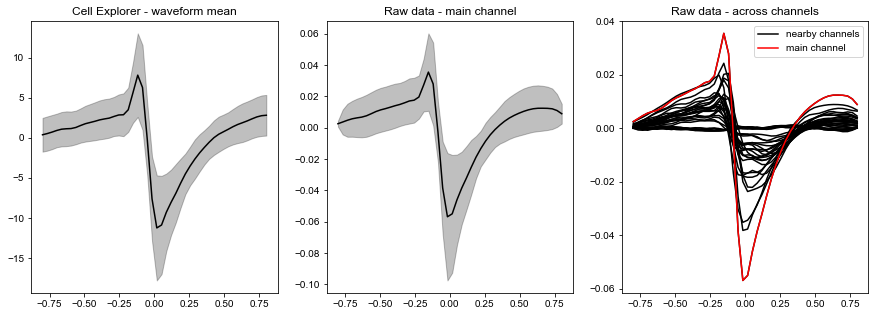

In [11]:
# plot single unit data
fig, axes = plt.subplots(1, 3, figsize=(15,5))

# plot average waveform from cell explorer
wf_mean = example_unit['waveform_mean']
wf_sd = example_unit['waveform_sd']
times = np.linspace(-time_window, time_window, len(wf_mean))
axes[0].plot(times, wf_mean, 'k')
axes[0].fill_between(times, wf_mean - wf_sd, wf_mean + wf_sd, color='k', alpha=0.25)
axes[0].set_title('Cell Explorer - waveform mean')

# plot individual waveforms grabbed from raweeg
times = np.linspace(-time_window, time_window, np.shape(spike_wfs_mean)[1])
mean_to_plot = spike_wfs_mean_main_channel.T
sd_to_plot = spike_wfs_sd_main_channel.T
axes[1].plot(times, mean_to_plot, 'k')
axes[1].fill_between(times, mean_to_plot - sd_to_plot, mean_to_plot + sd_to_plot, color='k', alpha=0.25)
axes[1].set_title('Raw data - main channel')

# plot avg waveform from raweeg
for ch in range(channel_window*2):
    mean_to_plot = spike_wfs_mean[ch,:].T
    sd_to_plot = spike_wfs_sd[ch,:].T
    axes[2].plot(times, mean_to_plot, 'k')
    axes[2].set_title('Raw data - across channels')
axes[2].plot(times, mean_to_plot, 'k', label='nearby channels')
axes[2].plot(times, spike_wfs_mean_main_channel, 'r', label='main channel')
axes[2].legend()


In [12]:
io.close()